# Quantum Walks and Monte Carlo

First, let's install the required Qiskit libraries

In [1]:
!pip install qiskit[visualization]
!pip install qiskit-aer
!pip install qiskit-ibm-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.7 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=4798963dc8b679b7981e32181261c27b2ccac5c82f0fc6989f2a6fae67db1f70
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We can now import the tools we'll need to create the Quantum Galton Board (QGB)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import generate_preset_pass_manager
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_distribution

from qiskit_aer import AerSimulator, StatevectorSimulator

from qiskit_ibm_runtime import SamplerV2 as Sampler

Each peg of the QGB id modelled by the following function

In [3]:
def add_peg(qc: QuantumCircuit, p: int):
    '''Add new peg to qc at qubit p
    @param qc: quantum circuit representing the QGB
    @param p: new pag's qubit index
    '''
    qc.cswap(0, p-1, p)
    qc.cx(p, 0)
    qc.cswap(0, p, p+1)

Now we can construct the QGB

In [4]:
def qgb(n: int, show = False) -> QuantumCircuit:
    '''The Quantum Galton Board
    @param n: number of layers
    @param show: plot the circuit
    '''

    # We need 1 control qubit and 2n+1 working qubits
    q = QuantumRegister(2 + 2 * n, 'q')
    # We also need n+1 measurements
    c = ClassicalRegister(n + 1, 'c')

    qc = QuantumCircuit(q, c)

    # The ball is dropped on the center peg
    b = n+1 # ball
    qc.x(b)

    # We now construct each layer of the QGB
    for l in range(n):
        # We reset the control qubit at the begining of each but the first layer
        if l > 0:
            qc.reset(0)
        # The ball has a 50/50 chance to go left or right
        qc.h(0)
        # We add the l+1 pegs in each layer
        for p in range(b-l, b+l+1, 2):
            # We add the extra CNOT between pegs
            if p > b - l:
                qc.cx(p-1, 0)
            add_peg(qc, p)

    # Finally, we add the n+1 measurement gates
    qc.barrier()
    qc.measure(range(1, 2 + 2 * n, 2), c)

    if show:
        display( qc.draw(output='mpl', fold=-1) )
    return qc

We can use the QGB as a universal statistical simulator

In [5]:
def simulate(qc: QuantumCircuit):
    '''Monte Carlo simulation of a quantum walk
    @param qc: quantum circuit representing the QGB
    '''

    # Set up the backend
    backend = StatevectorSimulator()

    # Transpile the circuit
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    qc_isa = pm.run(qc)


    # Set up the sampler
    sampler = Sampler(mode=backend)
    job = sampler.run([qc_isa], shots = 1000)

    # Get the measurement counts
    result = job.result()
    counts = result[0].data.c.get_counts()
    print(f'Counts: {dict(sorted(counts.items()))}')

    display( plot_distribution(counts) )

## Noiseless simulations

Creating a 4 layer balanced QGB

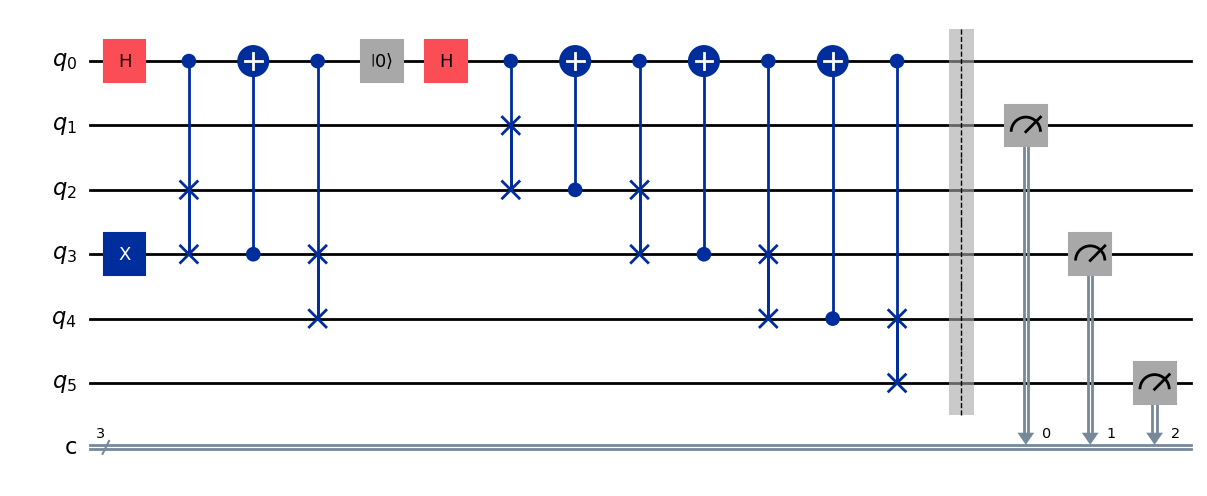

Counts: {'001': 232, '010': 504, '100': 264}


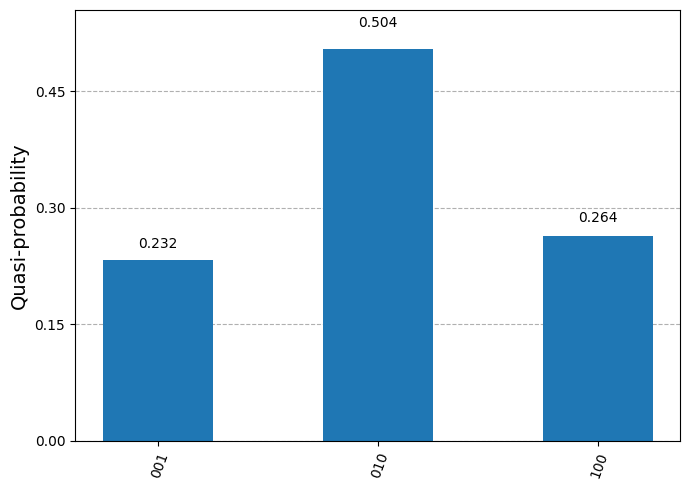

In [6]:
qc = qgb(2, show=True)
simulate(qc)